## Imports

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19

## Data Preparations

### 1. Load data files

In [ ]:
# load the data from keras datasets
fashion_mnist = tf.keras.datasets.fashion_mnist
# divide the data into train and test
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data() 

### 1.1 Describe the data

In [ ]:
# shape of train data
print('The train data has', X_train.shape[0], 'examples with shape', X_train.shape[1:])

The train data has 60000 examples with shape (28, 28)


In [ ]:
# shape of test data
print('The test data has', X_test.shape[0], 'examples with shape', X_test.shape[1:])

The test data has 10000 examples with shape (28, 28)


In [ ]:
classes_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
unique_labels = np.unique(y_train)
labels_dict = {classes_names[i]: unique_labels[i] for i in range(len(unique_labels))}
for class_name, label in labels_dict.items():
    print('The label', label, 'represents a class that is', class_name)

The label 0 represents a class that is T-shirt/top
The label 1 represents a class that is Trouser
The label 2 represents a class that is Pullover
The label 3 represents a class that is Dress
The label 4 represents a class that is Coat
The label 5 represents a class that is Sandal
The label 6 represents a class that is Shirt
The label 7 represents a class that is Sneaker
The label 8 represents a class that is Bag
The label 9 represents a class that is Ankle boot


### 1.5 Draw some of the images

Some of the images from fashion-MNIST:


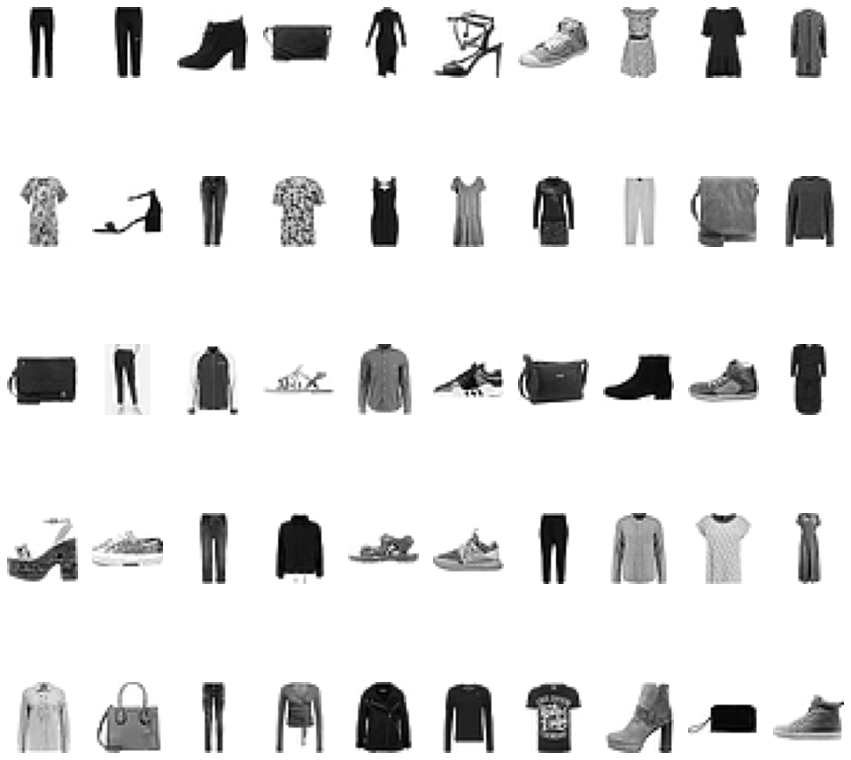

In [ ]:
def draw_images(data, num_of_images):
    '''
    This function draws a random images from the data, by specifying how many images to draw
    '''
    random_indexes = [np.random.randint(0, len(X_train)) for i in range(num_of_images)]
    fig , axis = plt.subplots(5,10)
    fig.set_figwidth(15)
    fig.set_figheight(15)
    i , j = 0 , 0
    for idx in random_indexes:
        image = X_train[idx]
        axis[i,j].imshow(image, cmap='binary')
        axis[i,j].axis('off')
        j += 1
        if j % 10 == 0:
            i += 1
            j = 0
# draw some images
print('Some of the images from fashion-MNIST:')
draw_images(data=X_train, num_of_images=50)

### 2. Carry out required preprocessing operations on the data

In [ ]:
# normalize train and test data
X_train = X_train / 255.0
X_test = X_test / 255.0
# add channel dimension for train and test data to be suitable for the CNN network
X_train = np.expand_dims(X_train,axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

### 3. Encode the labels

In [ ]:
# encode train and test labels
y_train_encoded = pd.get_dummies(y_train)
y_test_encoded = pd.get_dummies(y_test)

## Training a CNN neural network

### Plot Utility

In [ ]:
def train_curves(history, special_title):
    '''
    This function draws accuracy and loss curves for each epoch between train and validation data
    '''
    title_loss = 'Model loss per epoch ' + special_title
    title_accuracy = 'Model accuracy per epoch ' + special_title
    fig , axis = plt.subplots(nrows=1, ncols=2)
    # dimensions of figure
    fig.set_figheight(6)
    fig.set_figwidth(14)
    # loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    # accuracy
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epoch = np.arange(150)
    # loss curve
    axis[0].plot(loss,label='Train')
    axis[0].plot(val_loss,label='Validation')
    axis[0].set_xlabel('epoch')
    axis[0].set_ylabel('loss')
    axis[0].set_title(title_loss)
    axis[0].legend()
    # accuracy curve
    axis[1].plot(accuracy, label='Train')
    axis[1].plot(val_accuracy, label='Validation')
    axis[1].set_xlabel('epoch')
    axis[1].set_ylabel('accuracy')
    axis[1].set_title(title_accuracy)
    axis[1].legend()

### Evaluation Utilities

In [ ]:
def k_fold_cross_validation(X, y, network_type, k):
  '''
  This function evaluates the model by performing k fold cross validation
  '''
  # instantiate k_fold 
  k_fold = StratifiedKFold(k, shuffle=True, random_state=42)
  # output lists that will hold accuracy and loss for both train and validation
  # for each fold
  history_list = []
  accuracy_list = []
  val_accuracy_list = []
  val_loss_list = []
  loss_list = []
  # loop through the 5 folds
  for train_idx , val_idx in k_fold.split(X,y):
    # determine from the train data which fold will be used for validation, and the other will be for training
    X_train , y_train = X[train_idx], y[train_idx]
    X_val , y_val = X[val_idx], y[val_idx]
    # encode the labels
    y_train , y_val = pd.get_dummies(y_train) , pd.get_dummies(y_val)
    if network_type == 'LeNet-5':
      model = lenet_5()
    elif network_type == 'modified LeNet-5':
      # number of filters in the first convolutional layer
      filters1= 16
      # number of filters in the second convolutional layer (third layer in the network)
      filters3=16
      # this is the number of hidden nodes in the 5 layer of the network that it is after the flatten layer
      units5=256
      # this is the number of hidden nodes in the 6 layer of the network that it is before the output layer
      units6=128
      model = lenet_5(filters1= filters1, filters3=filters3, units5=units5, units6=units6)
    # training...
    history = model.fit(x= X_train, y= y_train, epochs=25, batch_size= 256, validation_data= (X_val, y_val), verbose= 0)
    # accuracy and loss after the completion of training
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    history_list.append(history)
    accuracy_list.append(accuracy)
    loss_list.append(loss)
    val_accuracy_list.append(val_accuracy)
    val_loss_list.append(val_loss)
  # get the mean of results for all folds
  mean_accuracy = np.mean(accuracy_list)
  mean_val_accuracy = np.mean(val_accuracy_list)
  mean_loss = np.mean(loss_list)
  mean_val_loss = np.mean(val_loss_list)
  return history_list, mean_accuracy, mean_val_accuracy, mean_loss,  mean_val_loss

In [ ]:
def cross_validation_report(history_list, mean_accuracy, mean_val_accuracy, mean_loss,  mean_val_loss, k, title):
  print('The mean accuracy of the model after', k, 'fold cross validation is:', mean_accuracy)
  print('The mean validation accuracy of the model after', k, 'fold cross validation is:', mean_val_accuracy)
  print('The mean loss of the model after', k, 'fold cross validation is:', mean_loss)
  print('The mean validation loss of the model after', k, 'fold cross validation is:', mean_val_loss)
  for i, history in enumerate(history_list,start=1):
    train_curves(history, 'of fold-' + str(i) + title)

### LeNet-5 Architecture

In [ ]:
def lenet_5(filters1 = 6, kernel_size1 = (5,5), strides1 = (1,1), padding1 = 'valid', pool_size2 = (2,2), strides2 = 2, filters3 = 16, 
            kernel_size3 = (5,5), strides3 = (1,1), padding3 = 'valid', pool_size4 = (2,2), strides4 = 2, units5 = 120, units6 = 84):
    '''
    This function defines the architecure of LeNet-5
    '''
    # define architecture
    model = Sequential([
        Input(shape=(28,28,1)),
        Conv2D(filters= filters1, kernel_size= kernel_size1, strides= strides1, padding= padding1),
        AveragePooling2D(pool_size = pool_size2, strides = strides2),
        Conv2D(filters= filters3, kernel_size= kernel_size3, strides= strides3, padding= padding3),
        AveragePooling2D(pool_size= pool_size4, strides= strides4),
        Flatten(),
        Dense(units= units5, activation= 'relu'),
        Dense(units= units6, activation= 'relu'),
        Dense(units= 10, activation= 'softmax')
    ])
    # compile the model
    model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])
    return model

In [ ]:
# initialize the model and output the model summary
lenet5 = lenet_5()
lenet5.summary()

2022-12-24 18:01:49.237044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 18:01:49.311745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 18:01:49.312509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 18:01:49.313828: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               30840     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

node zero
2022-12-24 18:01:49.314880: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 18:01:49.315515: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 18:01:51.104060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 18:01:51.105024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 18:01:51.105728: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node r

2022-12-24 18:01:52.288909: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-24 18:01:53.501756: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


The mean accuracy of the model after 5 fold cross validation is: 0.8673538308143616
The mean validation accuracy of the model after 5 fold cross validation is: 0.8618226656913758
The mean loss of the model after 5 fold cross validation is: 0.36066304552555084
The mean validation loss of the model after 5 fold cross validation is: 0.38239768409729


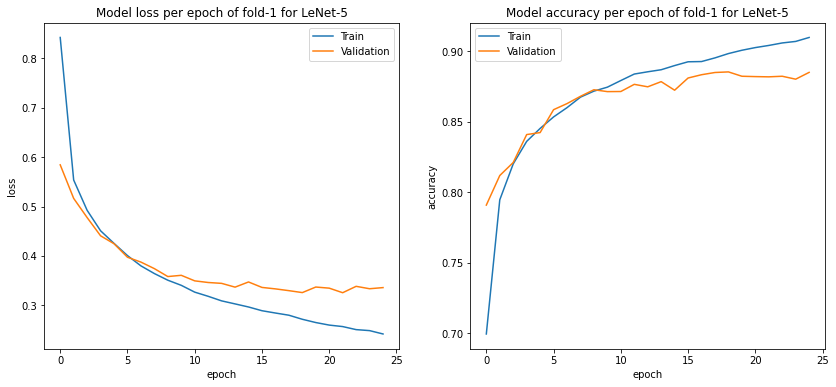

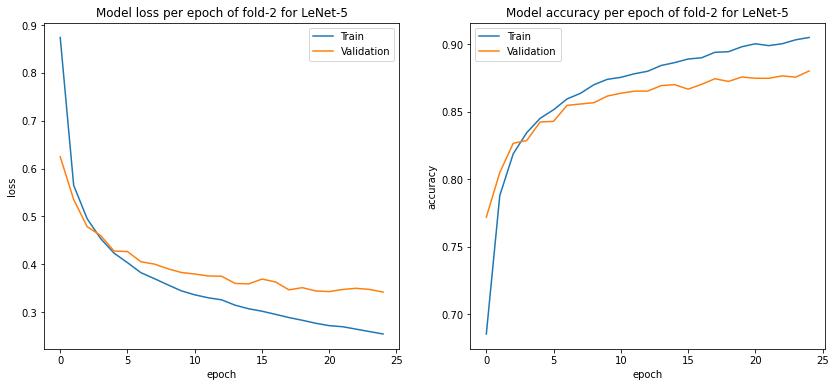

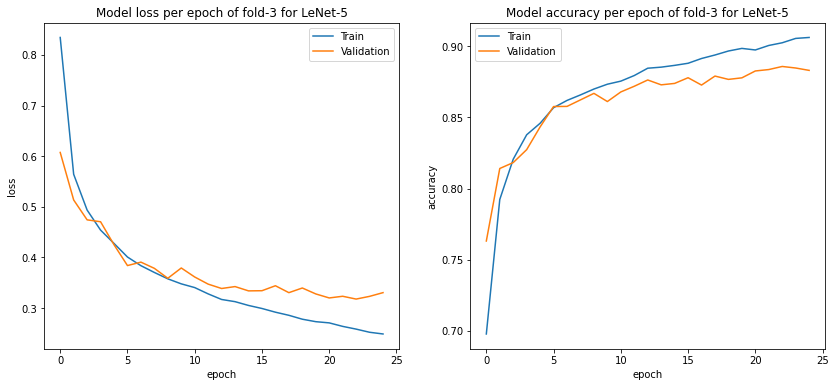

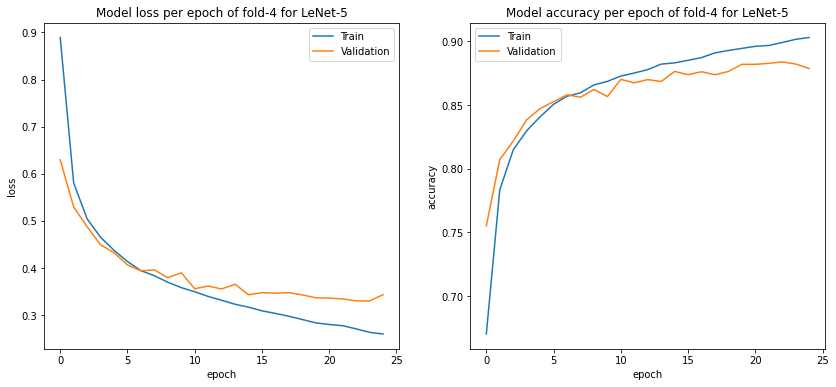

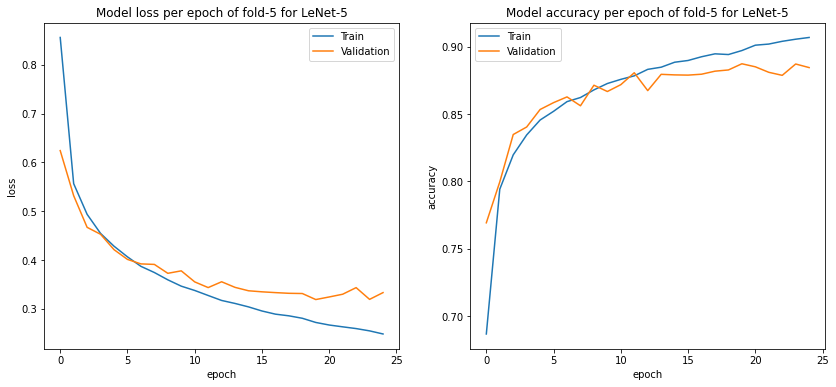

In [ ]:
# perform 5 fold cross validation on the LeNet-5 model and visualize the results
histories, mean_accuracy, mean_validation_accuracy, mean_loss, mean_validation_loss = k_fold_cross_validation(X_train, y_train, 'LeNet-5', 5)
cross_validation_report(histories, mean_accuracy, mean_validation_accuracy, mean_loss, mean_validation_loss, 5, ' for LeNet-5')

### Modify the Hyperparameters of LeNet-5 Architecture

In [ ]:
# hyperparameters
# number of filters in the first convolutional layer
filters1= 16
# number of filters in the second convolutional layer (third layer in the network)
filters3=16
# this is the number of hidden nodes in the 5 layer of the network that it is after the flatten layer
units5=256
# this is the number of hidden nodes in the 6 layer of the network that it is before the output layer
units6=128

In [ ]:
# initialize the model and output the model summary
modified_lenet5 = lenet_5(filters1= filters1, filters3=filters3, units5=units5, units6=units6)
modified_lenet5.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 24, 24, 16)        416       
_________________________________________________________________
average_pooling2d_12 (Averag (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 16)          6416      
_________________________________________________________________
average_pooling2d_13 (Averag (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_19 (Dense)             (None, 128)              

The mean accuracy of the model after 5 fold cross validation is: 0.8881416673660278
The mean validation accuracy of the model after 5 fold cross validation is: 0.8730719995498657
The mean loss of the model after 5 fold cross validation is: 0.30128026044368744
The mean validation loss of the model after 5 fold cross validation is: 0.36279642176628113


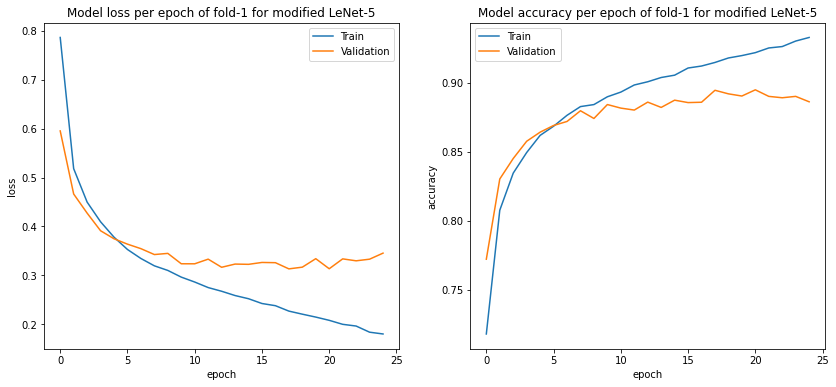

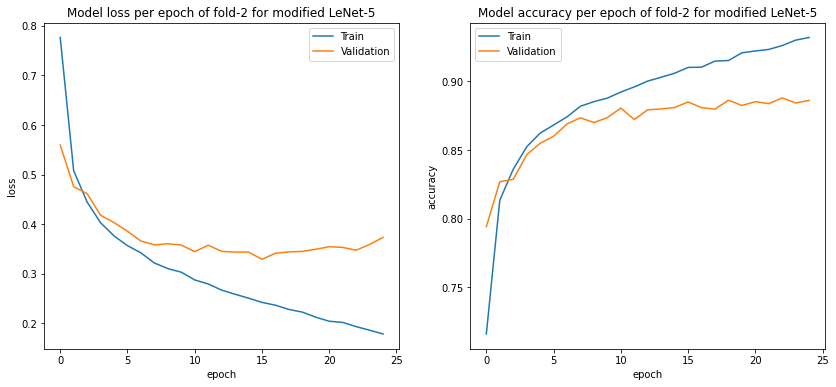

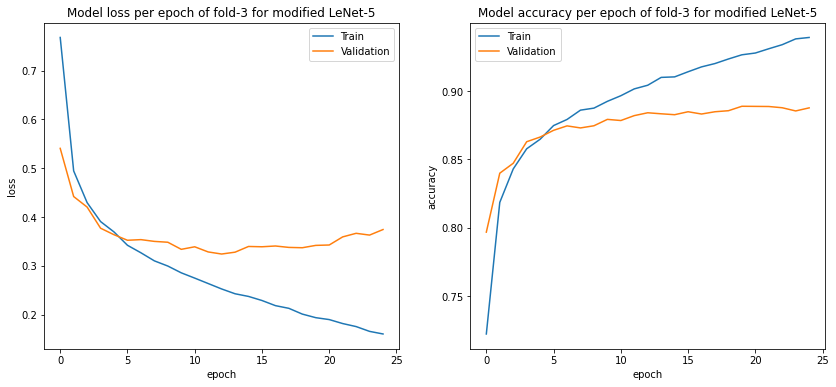

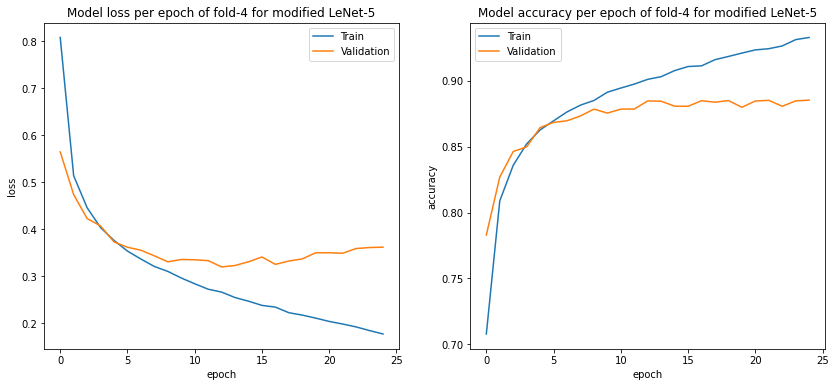

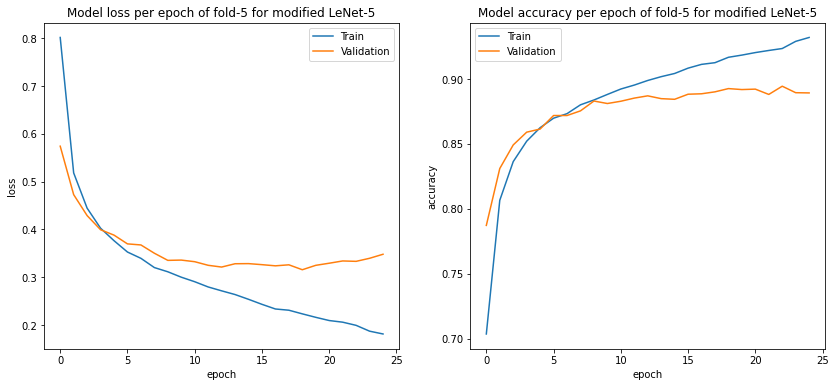

In [ ]:
# perform 5 fold cross validation on the modified LeNet-5 model and visualize the results
histories, mean_accuracy, mean_validation_accuracy, mean_loss, mean_validation_loss = k_fold_cross_validation(X_train, y_train,'modified LeNet-5', 5)
cross_validation_report(histories, mean_accuracy, mean_validation_accuracy, mean_loss, mean_validation_loss, 5, ' for modified LeNet-5')

So from above results we see that the **modified LeNet-5 Architecture** has higher mean accuracy and validation accuracy than the **standard LeNet-5** and a smaller mean loss and validation loss than **standard LeNet-5** so we will be using it to train once again on the full **Training Data** and evaluate the model on **Test Data** 

In [ ]:
# Training of the modified LeNet-5
history = modified_lenet5.fit(x= X_train,y= y_train_encoded, batch_size= 256, epochs= 25, validation_split= 0.1)

Epoch 1/25
211/211 [==============================] - 2s 5ms/step - loss: 0.7549 - accuracy: 0.7224 - val_loss: 0.5447 - val_accuracy: 0.8007
Epoch 2/25
211/211 [==============================] - 1s 4ms/step - loss: 0.4909 - accuracy: 0.8185 - val_loss: 0.4629 - val_accuracy: 0.8272
Epoch 3/25
211/211 [==============================] - 1s 4ms/step - loss: 0.4280 - accuracy: 0.8416 - val_loss: 0.4186 - val_accuracy: 0.8470
Epoch 4/25
211/211 [==============================] - 1s 4ms/step - loss: 0.3932 - accuracy: 0.8568 - val_loss: 0.3954 - val_accuracy: 0.8552
Epoch 5/25
211/211 [==============================] - 1s 4ms/step - loss: 0.3683 - accuracy: 0.8654 - val_loss: 0.3892 - val_accuracy: 0.8545
Epoch 6/25
211/211 [==============================] - 1s 4ms/step - loss: 0.3462 - accuracy: 0.8727 - val_loss: 0.3629 - val_accuracy: 0.8667
Epoch 7/25
211/211 [==============================] - 1s 5ms/step - loss: 0.3295 - accuracy: 0.8794 - val_loss: 0.3592 - val_accuracy: 0.8680
Epoch 

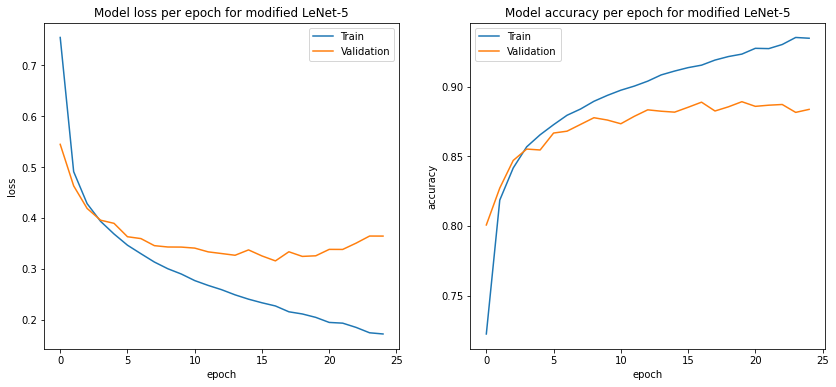

In [ ]:
# visualize accuracy and loss curves of modified LeNet-5
train_curves(history, 'for modified LeNet-5')

In [ ]:
# evaluation of the modified LeNet-5 on the test data
loss, accuracy = modified_lenet5.evaluate(x= X_test,y= y_test_encoded, batch_size= 256)
print('The loss of the modified LeNet-5 on test data is:', loss, 'and the accuracy is:', accuracy)

40/40 [==============================] - 0s 3ms/step - loss: 0.3941 - accuracy: 0.8794
The loss of the modified LeNet-5 on test data is: 0.3941136598587036 and the accuracy is: 0.8794000148773193


In [ ]:
# free memory ram resources from modified LeNet-5
del modified_lenet5
del history

### Transfer Learning

We will use other two CNNs Pretrained models and modify their **Architecture** to be suitable for number of classes in **Fashion-MNIST** dataset, and fine tune the pretrained models in our dataset

The Pretrained models are **VGG19** and **Inception_v3**

In [ ]:
def pretrained_model(network_type):
  '''
  This function instantiate the vgg19 or inception_v3 architecture and adding a 3 dense layers to be modified
  for the fashion_mnist dataset
  '''
  if network_type == 'VGG19':
    vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(32,32,3))
    for layer in  vgg19.layers:
      layer.trainable = False
    # define architecture
    model = Sequential([
        Input(shape=(32,32,3)),
        vgg19,
        Flatten(),
        Dense(units= 256, activation= 'relu'),
        Dense(units= 128, activation= 'relu'),
        Dense(units= 10, activation= 'softmax')
    ])
  elif network_type == 'Inception_v3':
    inception_v3 = InceptionV3(include_top=False, weights='imagenet', input_shape=(76,76,3))
    for layer in  inception_v3.layers:
      layer.trainable = False
    # define architecture
    model = Sequential([
        Input(shape=(76,76,3)),
        inception_v3,
        Flatten(),
        Dense(units= 256, activation= 'relu'),
        Dense(units= 128, activation= 'relu'),
        Dense(units= 10, activation= 'softmax')
    ])
  # compile the model
  model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])
  return model

In [ ]:
def transform_data(X_train, X_test, network_type):
  '''
  This Function modifies the train and test data to be with 3 channels instead of 1,
  also pad the images with zeros to reach the required shape of VGG19 or InceptionV3
  '''
  # number of examples in train and test data
  train_examples = len(X_train)
  test_examples = len(X_test)
  if X_train.shape[3] == 1 and X_test.shape[3] == 1:
    # repeat the single channe 3 times
    X_train = np.repeat(X_train, 3, axis=3)
    X_test = np.repeat(X_test, 3, axis=3)
    if network_type == 'VGG19':
      # reshape train and test data
      temp_train = X_train
      temp_test = X_test
      X_train = np.zeros((train_examples,32,32,3))
      X_test = np.zeros((test_examples,32,32,3))
      X_train[:,2:30,2:30,:] = temp_train
      X_test[:,2:30,2:30,:] = temp_test
      del temp_train
      del temp_test
    elif network_type == 'Inception_v3':
      # reshape train and test data
      temp_train = X_train
      temp_test = X_test
      X_train = np.zeros((train_examples,76,76,3))
      X_test = np.zeros((test_examples,76,76,3))
      X_train[:,24:52,24:52,:] = temp_train
      X_test[:,24:52,24:52,:] = temp_test
      del temp_train
      del temp_test
  else:
    if network_type == 'VGG19':
      # reshape train and test data
      temp_train = X_train
      temp_test = X_test
      X_train = np.zeros((train_examples,32,32,3))
      X_test = np.zeros((test_examples,32,32,3))
      X_train[:,2:30,2:30,:] = temp_train
      X_test[:,2:30,2:30,:] = temp_test
      del temp_train
      del temp_test
    elif network_type == 'Inception_v3':
      # reshape train and test data
      temp_train = X_train
      temp_test = X_test
      X_train = np.zeros((train_examples,76,76,3))
      X_test = np.zeros((test_examples,76,76,3))
      X_train[:,24:52,24:52,:] = temp_train
      X_test[:,24:52,24:52,:] = temp_test
      del temp_train
      del temp_test
  return X_train, X_test

### VGG19

In [ ]:
X_train_vgg19, X_test_vgg19 =  transform_data(X_train, X_test, network_type= 'VGG19')
print('The shape of the train data after reshaping for VGG19', X_train_vgg19.shape)
print('The shape of the test data after reshaping for VGG19', X_test_vgg19.shape)

The shape of the train data after reshaping for VGG19 (60000, 32, 32, 3)
The shape of the test data after reshaping for VGG19 (10000, 32, 32, 3)


In [ ]:
# VGG19 model
vgg19 = pretrained_model(network_type= 'VGG19')
vgg19.summary()

80150528/80134624 [==============================] - 4s 0us/step
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_12 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_37 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_38 (Dense)             (None, 10)                1290      
Total params: 20,189,898
Trainable params: 165,514
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
# Training of VGG19
history = vgg19.fit(x= X_train_vgg19,y= y_train_encoded, batch_size= 256, epochs= 25, validation_split= 0.1)

Epoch 1/25
211/211 [==============================] - 8s 30ms/step - loss: 0.6667 - accuracy: 0.7730 - val_loss: 0.4995 - val_accuracy: 0.8228
Epoch 2/25
211/211 [==============================] - 5s 24ms/step - loss: 0.4514 - accuracy: 0.8365 - val_loss: 0.4335 - val_accuracy: 0.8445
Epoch 3/25
211/211 [==============================] - 5s 24ms/step - loss: 0.3998 - accuracy: 0.8563 - val_loss: 0.4049 - val_accuracy: 0.8550
Epoch 4/25
211/211 [==============================] - 5s 25ms/step - loss: 0.3827 - accuracy: 0.8616 - val_loss: 0.3857 - val_accuracy: 0.8617
Epoch 5/25
211/211 [==============================] - 5s 24ms/step - loss: 0.3610 - accuracy: 0.8689 - val_loss: 0.3828 - val_accuracy: 0.8602
Epoch 6/25
211/211 [==============================] - 5s 24ms/step - loss: 0.3461 - accuracy: 0.8754 - val_loss: 0.3767 - val_accuracy: 0.8623
Epoch 7/25
211/211 [==============================] - 5s 24ms/step - loss: 0.3367 - accuracy: 0.8770 - val_loss: 0.3771 - val_accuracy: 0.8635

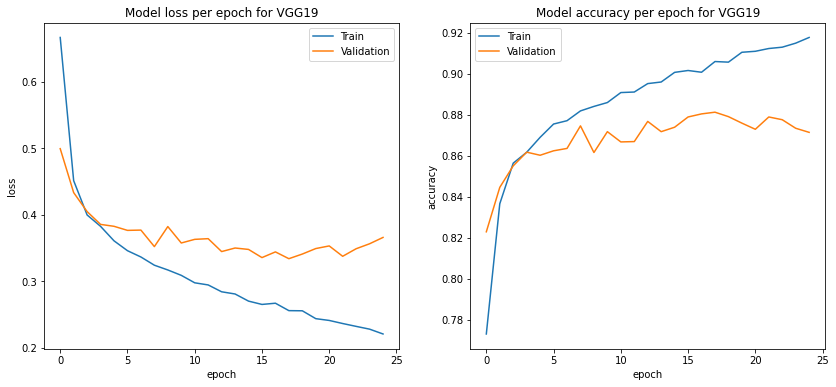

In [ ]:
# visualize accuracy and loss curves of VGG19
train_curves(history, 'for VGG19')

In [ ]:
# evaluation of the VGG19 on the test data
loss, accuracy = vgg19.evaluate(x= X_test_vgg19,y= y_test_encoded, batch_size= 256)
print('The loss of the VGG19 on test data is:', loss, 'and the accuracy is:', accuracy)

40/40 [==============================] - 1s 23ms/step - loss: 0.3912 - accuracy: 0.8627
The loss of the VGG19 on test data is: 0.39119964838027954 and the accuracy is: 0.8626999855041504


In [ ]:
# free memory ram resources from VGG19
del vgg19
del history
del X_train_vgg19
del X_test_vgg19

### InceptionV3

In [ ]:
X_train_inception_v3, X_test_inception_v3 =  transform_data(X_train, X_test, network_type= 'Inception_v3')
print('The shape of the train data after reshaping for InceptionV3', X_train_inception_v3.shape)
print('The shape of the test data after reshaping for InceptionV3', X_test_inception_v3.shape)

The shape of the train data after reshaping for InceptionV3 (60000, 76, 76, 3)
The shape of the test data after reshaping for InceptionV3 (10000, 76, 76, 3)


In [ ]:
# InceptionV3 model
inception_v3 = pretrained_model(network_type= 'Inception_v3')
inception_v3.summary()

2022-12-24 18:09:52.325045: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 18:09:52.413882: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 18:09:52.414669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 18:09:52.415879: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 22,361,514
Trainable params: 558,730
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
# Training of InceptionV3
history = inception_v3.fit(x= X_train_inception_v3,y= y_train_encoded, batch_size= 256, epochs= 25, validation_split= 0.1)

2022-12-24 18:10:12.682678: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3742848000 exceeds 10% of free system memory.
2022-12-24 18:10:17.054929: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3742848000 exceeds 10% of free system memory.
2022-12-24 18:10:20.188200: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-12-24 18:10:24.877179: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


211/211 [==============================] - 26s 73ms/step - loss: 0.5815 - accuracy: 0.7934 - val_loss: 0.4841 - val_accuracy: 0.8232
Epoch 2/25
211/211 [==============================] - 10s 49ms/step - loss: 0.4158 - accuracy: 0.8475 - val_loss: 0.4480 - val_accuracy: 0.8340
Epoch 3/25
211/211 [==============================] - 11s 50ms/step - loss: 0.3701 - accuracy: 0.8621 - val_loss: 0.4447 - val_accuracy: 0.8340
Epoch 4/25
211/211 [==============================] - 11s 50ms/step - loss: 0.3335 - accuracy: 0.8767 - val_loss: 0.4180 - val_accuracy: 0.8475
Epoch 5/25
211/211 [==============================] - 10s 49ms/step - loss: 0.2994 - accuracy: 0.8875 - val_loss: 0.4231 - val_accuracy: 0.8465
Epoch 6/25
211/211 [==============================] - 10s 50ms/step - loss: 0.2742 - accuracy: 0.8975 - val_loss: 0.4236 - val_accuracy: 0.8472
Epoch 7/25
211/211 [==============================] - 11s 50ms/step - loss: 0.2493 - accuracy: 0.9076 - val_loss: 0.4207 - val_accuracy: 0.8527
Epo

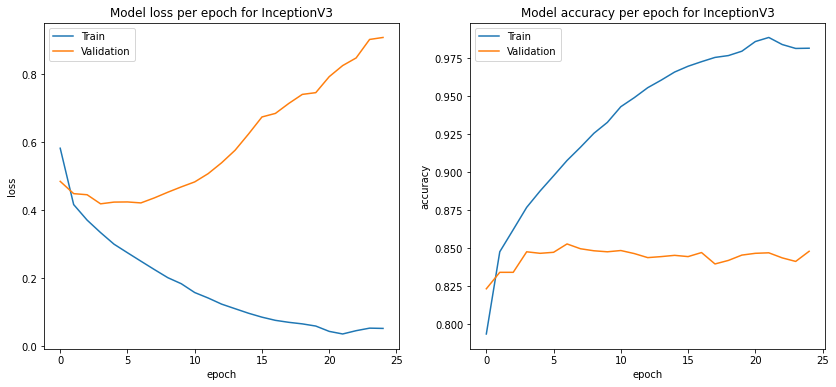

In [ ]:
# visualize accuracy and loss curves of InceptionV3
train_curves(history, 'for InceptionV3')

In [ ]:
# evaluation of the InceptionV3 on the test data
loss, accuracy = inception_v3.evaluate(x= X_test_inception_v3,y= y_test_encoded, batch_size= 256)
print('The loss of the VGG19 on test data is:', loss, 'and the accuracy is:', accuracy)

40/40 [==============================] - 2s 48ms/step - loss: 0.9360 - accuracy: 0.8400
The loss of the VGG19 on test data is: 0.9359815716743469 and the accuracy is: 0.8399999737739563
